# MSE and RSA

## Imports

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import time
import pandas as pd
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import seaborn as sns
from sklearn.decomposition import PCA
from make_models import get_MRI_CVAE_3D
from tqdm import tqdm
import tensorflow as tf
from rsa_funcs import fit_rsa,make_RDM,get_triu

/data/bergerar/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
pwd

'/mmfs1/data/bergerar/BC-MRI-ADHD/Code'

## Load and Sort Data

In [3]:
stuff = np.load('../Assets/brain_array-440.npz')
print(list(stuff.keys()))

data = stuff['data']
control = stuff['controls']
patients = stuff['patients']
n = data.shape[0]
#print(data.shape)
#data[patients,:,:,:].shape
#data[patients].shape

data_patients = data[patients,:,:,:]
data_controls = data[control,:,:,:]

print(data_patients.shape)
print(data_controls.shape)

['data', 'controls', 'patients']
(179, 64, 64, 64)
(261, 64, 64, 64)


## CVAE

In [4]:
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
                    latent_dim=2,
                    beta=1,
                    disentangle=False,
                    gamma=1,
                    bias=True,
                    batch_size = 64,
                    kernel_size = 3,
                    filters = 32,
                    intermediate_dim = 128,
                    opt=None)

## Load Weights

In [5]:
cvae.load_weights('../Assets/tf_weights_10000_AB/tf_weightsAB')

In [6]:
data_patients.shape

(179, 64, 64, 64)

## Get Reconstructions

In [7]:
def get_reconstruction(data_in,adhd = True):

    z = z_encoder.predict(data_in)[0] # mu,std,sample
    s = s_encoder.predict(data_in)[0]

    if adhd==True:
        l = np.hstack((z,s))
    else:
        l = np.hstack((z,np.zeros(s.shape)))

    recon = cvae_decoder(l)[:,:,:,:,0]
    return recon

In [8]:
%%time
recon_patients = get_reconstruction(data_patients,adhd = True)
recon_controls = get_reconstruction(data_controls,adhd = False)


CPU times: user 1min 50s, sys: 26.1 s, total: 2min 16s
Wall time: 28.5 s


In [9]:
recon_patients.shape

TensorShape([179, 64, 64, 64])

In [10]:
np.array(recon_patients).max()

0.8697046

In [11]:
np.array(recon_patients).min()

0.008435845

In [12]:
np.array(data_patients).max()


1.0

In [13]:
np.array(data_patients).min()


0.0

## Reconstruction: Subject 0

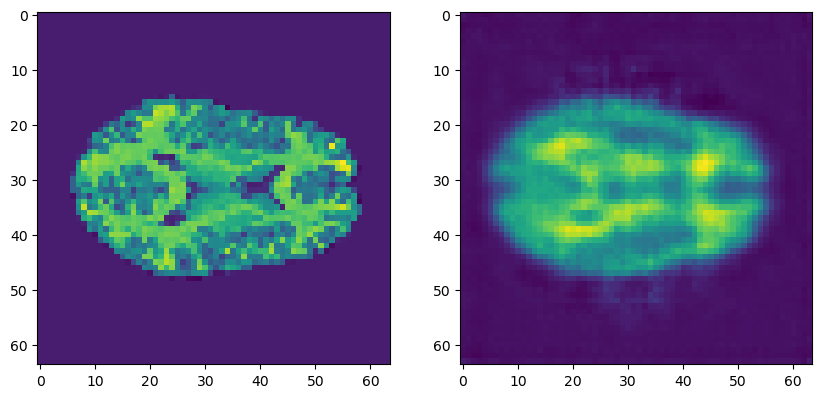

In [14]:
s = 0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

## MSE: Subject 0

In [15]:
data = data_patients[0,:,:,:]
predict = recon_patients[0,:,:,:]
# Using 'auto'/'sum_over_batch_size' reduction type.
mse = tf.keras.losses.MeanSquaredError()
mse(data, predict).numpy()

0.001449396

In [16]:
data = np.array(data_patients[0,:,:,:])
predict = np.array(recon_patients[0,:,:,:])
mse = ((data-predict)**2).mean()

## Reconstruction: Subject 1

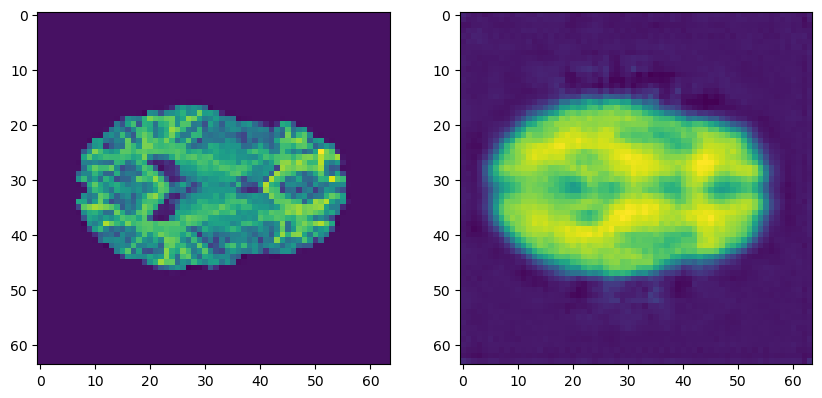

In [17]:
s = 1
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

## Reconstruction: Subject 2

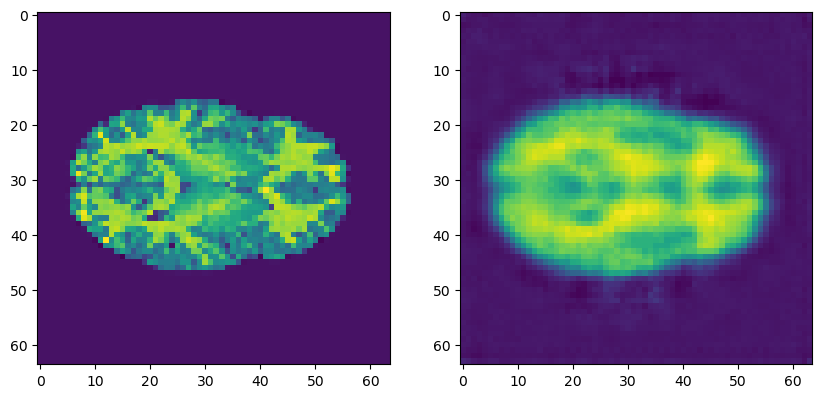

In [18]:
s = 2
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

## MSE loop

In [15]:
mse_list = []
for s in range(0,179):
    data = np.array(data_patients[s,:,:,:])
    predict = np.array(recon_patients[s,:,:,:])
    mse = ((data-predict)**2).mean()
    mse_list.append(mse)

mse_arr = np.array(mse_list)

## Mean Squared Error

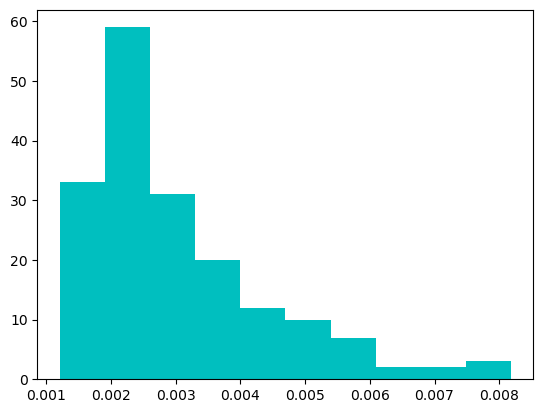

In [16]:
plt.hist(mse_arr, color='c')
plt.show()

In [17]:
np.argmin(mse_arr) #

5

## Reconstruction with Highest MSE

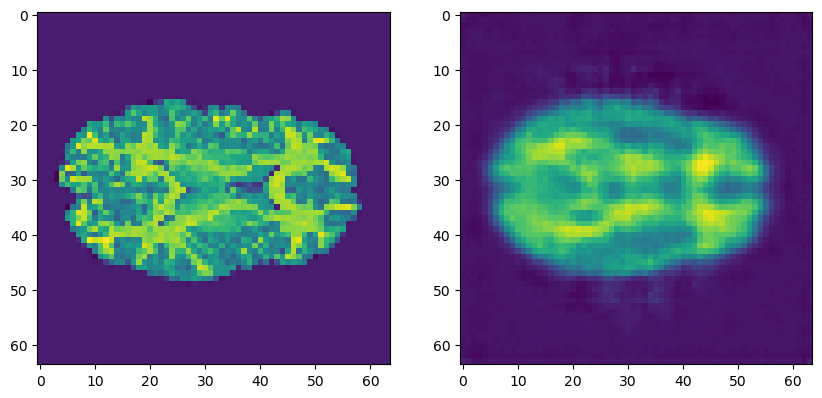

In [22]:
s = 5
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

In [23]:
np.argmax(mse_arr) #

154

## Reconstruction with Lowest MSE

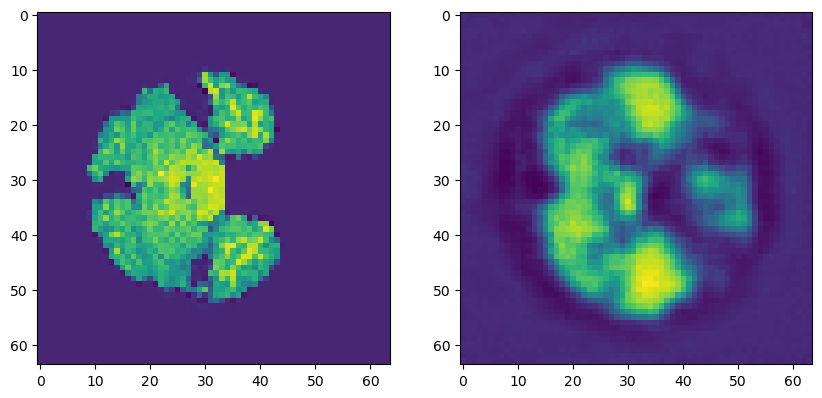

In [24]:
s = 154
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

## Read DF

In [18]:
df = pd.read_csv('../Data/df_440_normed.csv')

## Make ADHD Dataframe

In [19]:
ADHDdf = df[df['DX'] != 0]
TDdf = df[df['DX'] == 0]

In [27]:
# ADHDdf.to_csv('../Data/ADHDdf_179.csv')

In [20]:
ADHDdf

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  Subject  \
1             1            27              27                27       27   
4             4            30              30                30       30   
7             7            33              33                33       33   
8             8            34              34                34       34   
9             9            35              35                35       35   
..          ...           ...             ...               ...      ...   
381         381           572             572               572      572   
383         383           577             577               577      577   
386         386           581             581               581      581   
393         393           602             602               602      602   
394         394           609             609               609      609   

     ScanDir ID  Site  Gender    Age  Handedness  ...  QC_Rest_3 QC_Rest_4  \
1     2026113.0     3     0.0  12.99         1.0  ...        NaN       NaN   
4     1623716.0     3     0.0  12.65         1.0  ...        NaN       NaN   
7     3154996.0     3     1.0  11.65         1.0  ...        NaN       NaN   
8     3160561.0     3     1.0  11.95         1.0  ...        NaN       NaN   
9     4275075.0     3     0.0  10.50         1.0  ...        NaN       NaN   
..          ...   ...     ...    ...         ...  ...        ...       ...   
381   2367157.0     1     1.0  12.08         1.0  ...        NaN       NaN   
383   2697768.0     1     0.0  12.58         1.0  ...        NaN       NaN   
386   2897046.0     1     0.0   9.17         1.0  ...        NaN       NaN   
393   3976121.0     1     1.0  11.00         1.0  ...        NaN       NaN   
394   4334113.0     1     1.0  14.58         1.0  ...        NaN       NaN   

     QC_Anatomical_1  QC_Anatomical_2  ID        subID  has_brain  \
1                1.0              NaN NaN  sub-2026113       True   
4                1.0              NaN NaN  sub-1623716       True   
7                1.0              NaN NaN  sub-3154996       True   
8                1.0              NaN NaN  sub-3160561       True   
9                1.0              NaN NaN  sub-4275075       True   
..               ...              ...  ..          ...        ...   
381           -999.0              NaN NaN  sub-2367157       True   
383              1.0              NaN NaN  sub-2697768       True   
386              1.0              NaN NaN  sub-2897046       True   
393              1.0              NaN NaN  sub-3976121       True   
394           -999.0              NaN NaN  sub-4334113       True   

     ADHD Index Normed  Inattentive Normed  Hyper/Impulsive Normed  
1             0.847458                0.98                0.755102  
4             0.796610                1.00                1.000000  
7             0.406780                0.68                0.346939  
8             0.525424                0.44                0.591837  
9             0.796610                0.70                0.571429  
..                 ...                 ...                     ...  
381           1.000000                1.00                1.000000  
383           0.520833                0.68                0.375000  
386                NaN                 NaN                     NaN  
393           0.500000                0.60                0.416667  
394           0.625000                0.64                0.625000  

[179 rows x 34 columns]

## Notes on booleans

In [29]:
np.array(True) + np.array(False)
np.array(False) + np.array(False)
np.array(True) * np.array(False)
np.array(False) * np.array(False)
# for booleans + means or , * means and

False

In [30]:
~np.array(True)

False

## RDMS: ADHD Index

In [21]:
make_RDM??

Signature: make_RDM(inVec, data_scale='ratio', metric='euclidean')
Docstring: <no docstring>
Source:   
def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    # Makes an similarity matrix
    # Takes in a data matrix (n x p), subjects as rows, and abitrary number of features 
    # Whether you give it a 5x2 or a 5x10000 matrix, will give back a 5x5 similarity matrix
    # 
    vec = inVec # Takes whatever data you give it 
    vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten())) # Normalizes between 0 and 1
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose() # this is... just... magic. so beautiful. I mean really. 
        # ^ ok ok lemme explain 
        # pdist function below, works on >=2D data
        # this is a hack in case you want to use it on 1D data
        # in case you pass it a 1D vector, it adds a column of zeros
        # which doesnt change the distances, 
                   
 

In [22]:
symptom_vector = ADHDdf['ADHD Index Normed'].values
symptom_vector

array([0.84745763, 0.79661017, 0.40677966, 0.52542373, 0.79661017,
       0.84745763, 0.37288136, 0.33898305, 0.62711864, 0.40677966,
       0.45762712, 0.49152542, 0.52542373, 0.74576271, 0.37288136,
       0.62711864, 0.52542373, 0.37288136, 0.66101695, 0.45762712,
       0.66101695, 0.6440678 , 0.33898305, 0.62711864, 0.77966102,
       0.40677966, 0.37288136, 0.40677966, 0.38983051, 0.62711864,
       0.52542373, 0.61016949, 0.74576271, 0.33898305, 0.49152542,
       0.57627119, 0.25423729, 0.38983051, 0.59322034, 0.54237288,
       0.27118644, 0.62711864, 0.42372881, 0.71186441, 0.59322034,
       0.49152542, 0.61016949, 0.72881356, 0.55932203, 0.52542373,
       0.30508475, 0.84745763, 0.54237288, 0.66101695, 0.44067797,
       0.59322034, 0.40677966, 0.38983051, 0.77966102, 0.57627119,
       0.71186441, 0.57627119, 0.38983051, 0.55932203, 0.42372881,
       0.33898305, 0.54237288, 0.61016949, 0.37288136, 0.84745763,
       0.47457627, 0.74576271, 0.45762712, 0.61016949, 0.61016

In [23]:
is_999 = symptom_vector==-999

In [24]:
is_nan = np.isnan(symptom_vector)

In [25]:
is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [26]:
is_not_nan = ~is_nan
is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [27]:
is_not_999 = ~is_999
is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [28]:
good_subjects = is_not_999 * is_not_nan
good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [29]:
symptom_good_patients = symptom_vector[good_subjects]

In [30]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
symptom = np.array(symptom_good_patients)

In [31]:
z_good_patients = z_patients[good_subjects,:]

In [32]:
s_good_patients = s_patients[good_subjects,:]

In [33]:
s_patients_rdm = make_RDM(s_good_patients)
z_patients_rdm = make_RDM(z_good_patients)
symptom_rdm = make_RDM(symptom_good_patients)

In [34]:
symptom_rdm.shape

(147, 147)

In [35]:
z_patients_rdm.shape

(147, 147)

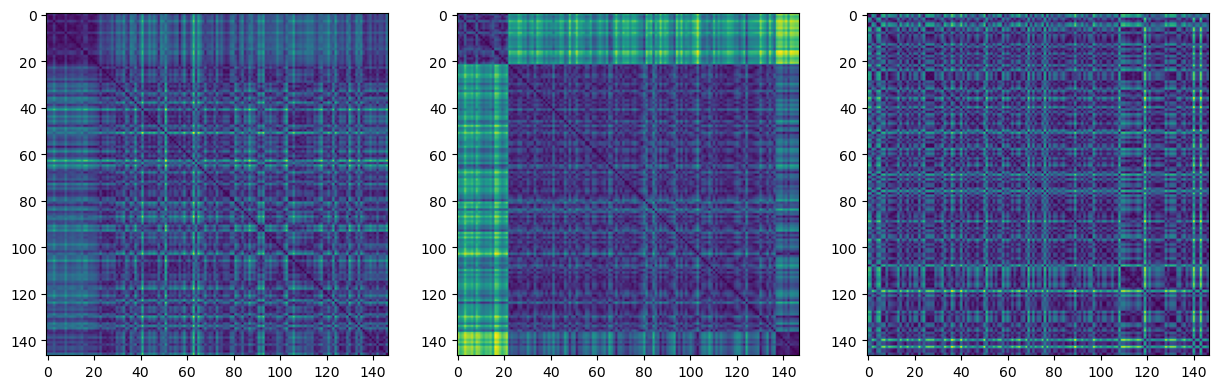

In [36]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm)
plt.subplot(1,3,3)
plt.imshow(symptom_rdm)
plt.show()

## RSA: ADHD Index

In [37]:
s_symptom_rsa = fit_rsa(s_patients_rdm, symptom_rdm)
s_symptom_rsa

-0.05405793976208963

In [38]:
z_symptom_rsa = fit_rsa(z_patients_rdm, symptom_rdm)
z_symptom_rsa

0.0343391801740558

## RDMS: Inattentive Index

In [39]:
inattentive_vector = ADHDdf['Inattentive Normed'].values
inattentive_vector

array([ 0.98,  1.  ,  0.68,  0.44,  0.7 ,  1.  ,  0.5 ,  0.5 ,  0.72,
        0.42,  0.48,  0.54,  0.4 ,  0.96,  0.4 ,  0.8 ,  0.68,  0.48,
        1.  ,  0.66,  0.7 ,  0.66,  0.32,  0.82,  0.84,  0.24,  0.52,
        0.58,  0.46,  0.72,  0.68,  0.74,  0.8 ,  0.42,  0.48,  0.56,
        0.22,  0.42,  0.68,  0.62,  0.44,  0.8 ,  0.48,  0.8 ,  0.6 ,
        0.66,  0.76,  1.  ,  0.66,  0.72,  0.5 ,  1.  ,  0.64,  0.86,
        0.8 ,  0.56,  0.5 ,  0.42,  0.88,  0.8 ,  0.78,  0.66,  0.42,
        0.56,  0.72,  0.48,  0.4 ,  0.66,  0.3 ,  1.  ,  0.48,  0.88,
        0.54,  0.58,  0.72,  0.48,  1.  ,  0.38,  0.54,  0.68,  0.72,
        0.66,  0.54,  0.7 ,  0.74,  0.78,  0.54,  0.38,   nan,  0.58,
        0.34,   nan,  0.82,  0.78,  0.56,  0.78,  0.64,  0.82,  0.78,
        0.22,  0.52,  0.76,  0.66,  0.64,  0.66,  0.58,  0.66,  0.82,
        0.58,  0.5 ,  1.  ,  0.48,  0.36,  0.36,  0.38,  0.52,  0.32,
        0.46,  0.32,  0.42,  0.66,  0.74,  0.64,  0.92,  0.58,  0.4 ,
        0.78,  0.68,

In [40]:
inattentive_is_999 = inattentive_vector==-999

In [41]:
inattentive_is_nan = np.isnan(inattentive_vector)

In [42]:
inattentive_is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [43]:
inattentive_is_not_nan = ~inattentive_is_nan
inattentive_is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [44]:
inattentive_is_not_999 = ~inattentive_is_999
inattentive_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [45]:
inattentive_good_subjects = inattentive_is_not_999 * inattentive_is_not_nan
inattentive_good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [46]:
inattentive_good_patients = inattentive_vector[inattentive_good_subjects]

In [47]:
z_good_patients_inattentive = z_patients[inattentive_good_subjects,:]
s_good_patients_inattentive = s_patients[inattentive_good_subjects,:]

In [48]:
s_patients_rdm_inattentive = make_RDM(s_good_patients_inattentive)
z_patients_rdm_inattentive = make_RDM(z_good_patients_inattentive)
inattentive_rdm = make_RDM(inattentive_good_patients)

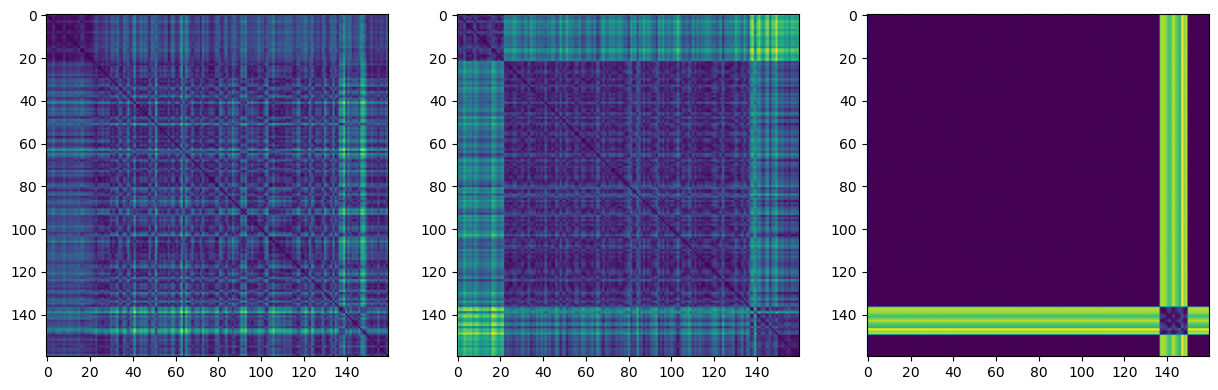

In [49]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_inattentive)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_inattentive)
plt.subplot(1,3,3)
plt.imshow(inattentive_rdm)
plt.show()

## RSA: Inattentive Index

In [50]:
s_inattentive_rsa = fit_rsa(s_patients_rdm_inattentive, inattentive_rdm)
s_inattentive_rsa

0.3869644622915321

In [51]:
z_inattentive_rsa = fit_rsa(z_patients_rdm_inattentive, inattentive_rdm)
z_inattentive_rsa

0.3911022182212048

## RDMS: Hyperactive/Impulsive Index

In [52]:
HI_vector = ADHDdf['Hyper/Impulsive Normed'].values
HI_vector

array([7.55102041e-01, 1.00000000e+00, 3.46938776e-01, 5.91836735e-01,
       5.71428571e-01, 1.00000000e+00, 4.08163265e-01, 5.10204082e-01,
       5.10204082e-01, 5.51020408e-01, 3.87755102e-01, 7.14285714e-01,
       5.10204082e-01, 6.93877551e-01, 4.08163265e-01, 8.57142857e-01,
       8.36734694e-01, 3.06122449e-01, 8.57142857e-01, 5.71428571e-01,
       8.57142857e-01, 9.79591837e-01, 1.42857143e-01, 7.95918367e-01,
       8.97959184e-01, 5.91836735e-01, 4.08163265e-02, 4.89795918e-01,
       2.24489796e-01, 9.38775510e-01, 4.28571429e-01, 5.51020408e-01,
       5.30612245e-01, 5.10204082e-01, 4.89795918e-01, 8.36734694e-01,
       4.48979592e-01, 3.67346939e-01, 6.32653061e-01, 7.75510204e-01,
       2.24489796e-01, 5.91836735e-01, 5.51020408e-01, 7.75510204e-01,
       5.10204082e-01, 6.73469388e-01, 6.32653061e-01, 4.89795918e-01,
       3.46938776e-01, 1.83673469e-01, 3.06122449e-01, 7.95918367e-01,
       6.32653061e-01, 7.14285714e-01, 5.71428571e-01, 4.48979592e-01,
      

In [53]:
HI_is_999 = HI_vector==-999

In [54]:
HI_is_nan = np.isnan(HI_vector)

In [55]:
HI_is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [56]:
HI_is_not_nan = ~HI_is_nan
HI_is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [57]:
HI_is_not_999 = ~HI_is_999
HI_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [58]:
HI_good_subjects = HI_is_not_999 * HI_is_not_nan
HI_good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [59]:
HI_good_patients = HI_vector[HI_good_subjects]

In [60]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
HI = np.array(HI_good_patients)

In [61]:
z_good_patients_HI = z_patients[HI_good_subjects,:]

In [62]:
s_good_patients_HI = s_patients[HI_good_subjects,:]

In [63]:
s_patients_rdm_HI = make_RDM(s_good_patients_HI)
z_patients_rdm_HI = make_RDM(z_good_patients_HI)
HI_rdm = make_RDM(HI_good_patients)

In [64]:
s_patients_rdm_HI.shape

(160, 160)

In [65]:
z_patients_rdm_HI.shape

(160, 160)

In [66]:
HI_rdm.shape

(160, 160)

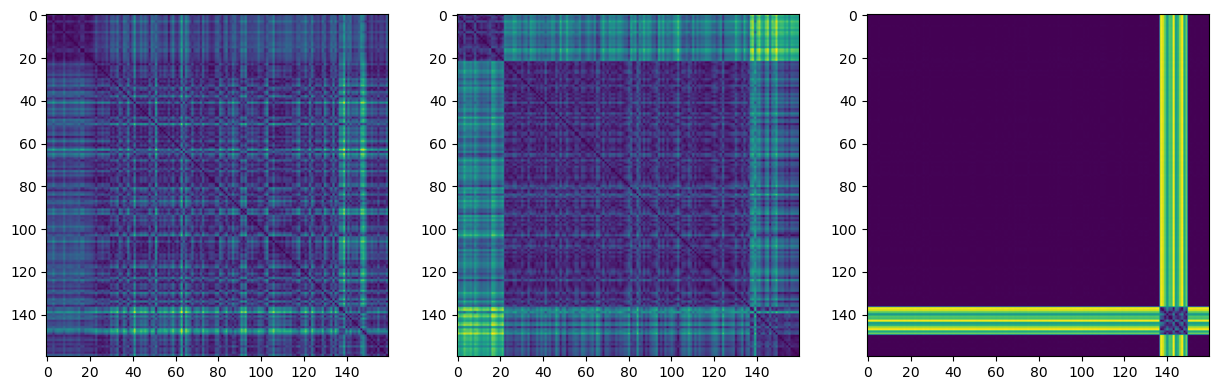

In [67]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_HI)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_HI)
plt.subplot(1,3,3)
plt.imshow(HI_rdm)
plt.show()

## RSA: Hyperactive/Impulsive Index

In [68]:
s_HI_rsa = fit_rsa(s_patients_rdm_HI, HI_rdm)
s_HI_rsa

0.3689519375335037

In [69]:
z_HI_rsa = fit_rsa(z_patients_rdm_HI, HI_rdm)
z_HI_rsa

0.3645124625503615

## RDMS: Age

In [70]:
age_vector = ADHDdf['Age'].values
age_vector

array([12.99, 12.65, 11.65, 11.95, 10.5 , 10.36,  8.72, 10.35, 11.04,
        9.97, 10.15, 11.89, 12.98,  8.1 ,  8.19,  8.99,  8.8 ,  9.08,
        8.45,  9.52,  9.43,  9.06,  8.29,  8.78,  8.04, 12.79,  9.57,
        8.61, 13.32,  8.56, 10.12, 10.06, 10.26, 11.18,  7.55,  7.26,
       13.56,  8.11, 10.41,  9.17, 12.07, 11.06, 11.53, 11.61, 13.49,
       10.78,  8.53,  8.38, 10.69,  9.17, 11.28, 12.28, 12.62,  8.49,
        8.61, 10.21, 10.36,  9.26,  7.86,  8.05,  9.24,  7.49,  9.38,
       11.97, 11.8 ,  9.32, 10.81,  9.23, 13.28, 10.16,  7.24, 11.33,
        9.92, 10.7 , 10.92,  9.98, 11.17, 11.92, 12.41, 11.54,  8.37,
       12.12,  9.42, 12.41, 11.1 ,  8.95, 10.9 , 10.65,  9.81, 17.43,
       15.4 , 15.63, 14.95,  8.75, 12.72, 11.41, 16.14, 15.9 ,  7.77,
       16.08, 17.37, 14.81,  8.19, 16.32,  8.93, 14.39, 14.94, 14.2 ,
       17.15, 13.24,  9.16, 15.32, 11.21, 11.82, 16.77, 13.33, 11.73,
        8.06, 11.09,  9.59, 15.81, 11.37, 15.83, 17.61,  8.75, 13.09,
       12.38,  7.35,

In [71]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
#age_vector

In [72]:
s_patients.shape

(179, 2)

In [73]:
z_patients.shape

(179, 2)

In [74]:
age_vector.shape

(179,)

In [75]:
s_patients_rdm_age = make_RDM(s_patients)
z_patients_rdm_age = make_RDM(z_patients)
age_rdm = make_RDM(age_vector)

In [76]:
s_patients_rdm_age.shape

(179, 179)

In [77]:
z_patients_rdm_age.shape

(179, 179)

In [78]:
age_rdm.shape

(179, 179)

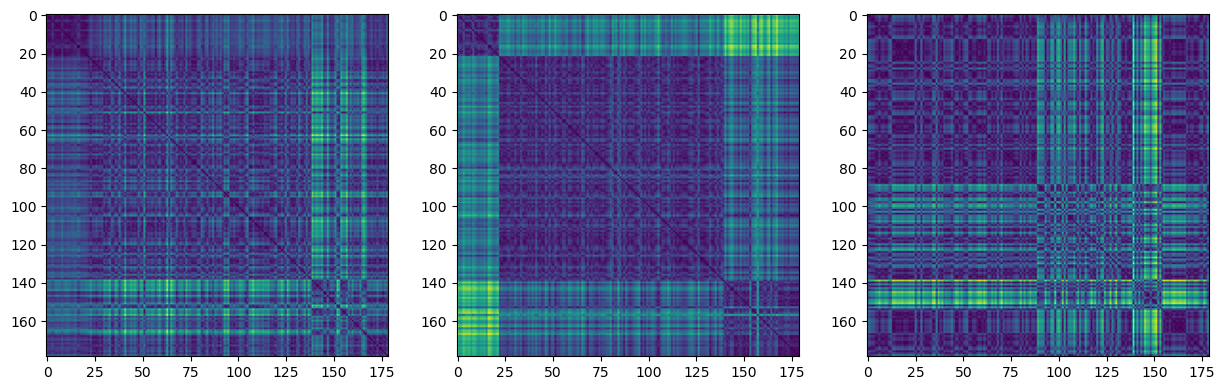

In [79]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_age)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_age)
plt.subplot(1,3,3)
plt.imshow(age_rdm)
plt.show()

## RSA: Age

In [80]:
s_age_rsa = fit_rsa(s_patients_rdm_age, age_rdm)
s_age_rsa

0.1066074889396527

In [81]:
z_age_rsa = fit_rsa(z_patients_rdm_age, age_rdm)
z_age_rsa

-0.050470670686496

## RDMS: Gender

In [82]:
gender_vector = ADHDdf['Gender'].values
gender_vector

array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,
        0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,
        1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,
        0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,
        1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.])

In [83]:
gender_is_999 = gender_vector==-999

In [84]:
gender_is_nan = np.isnan(gender_vector)

In [85]:
gender_is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [86]:
gender_is_not_nan = ~gender_is_nan
gender_is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [87]:
gender_is_not_999 = ~gender_is_999
gender_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [88]:
gender_good_subjects = gender_is_not_999 * gender_is_not_nan
gender_good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [89]:
gender_good_patients = gender_vector[gender_good_subjects]

In [90]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]

In [91]:
z_good_patients_gender = z_patients[gender_good_subjects,:]

In [92]:
s_good_patients_gender = s_patients[gender_good_subjects,:]

In [98]:
s_patients_rdm_gender = make_RDM(s_good_patients_gender)
z_patients_rdm_gender = make_RDM(z_good_patients_gender)
gender_rdm = make_RDM(gender_good_patients,data_scale='ordinal')

In [99]:
s_patients_rdm_gender.shape

(178, 178)

In [100]:
z_patients_rdm_gender.shape

(178, 178)

In [101]:
gender_rdm.shape

(178, 178)

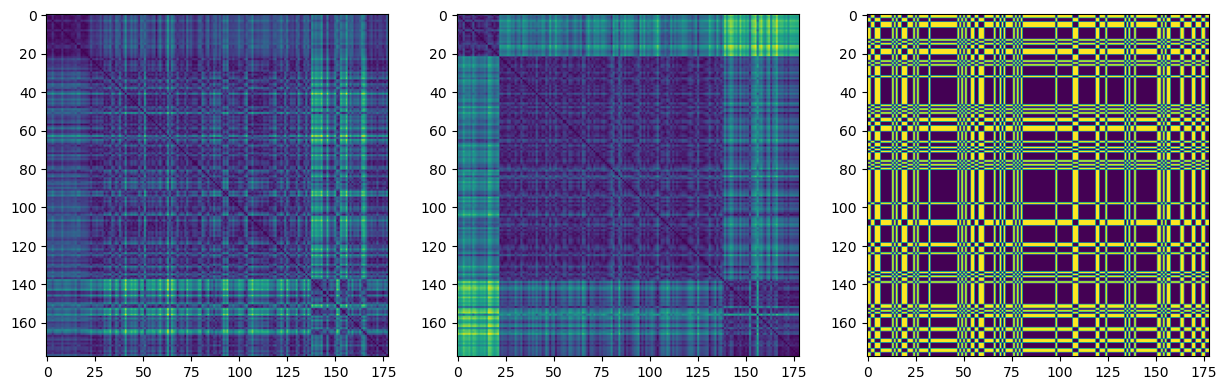

In [102]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_gender)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_gender)
plt.subplot(1,3,3)
plt.imshow(gender_rdm)
plt.show()

## RSA: Gender

In [103]:
s_gender_rsa = fit_rsa(s_patients_rdm_gender, gender_rdm)
s_gender_rsa

-0.00379574875173

In [104]:
z_gender_rsa = fit_rsa(z_patients_rdm_gender, gender_rdm)
z_gender_rsa

0.06638938554346467

## RDMS: Handedness

In [105]:
handed_vector = ADHDdf['Handedness'].values
handed_vector

array([ 1.00e+00,  1.00e+00,  1.00e+00,  1.00e+00,  1.00e+00,  1.00e+00,
        1.00e+00,  1.00e+00,  1.00e+00,  1.00e+00,  0.00e+00,  1.00e+00,
        1.00e+00,  1.00e+00,  1.00e+00,  1.00e+00,  1.00e+00,  0.00e+00,
        1.00e+00,  1.00e+00,  1.00e+00,  1.00e+00,  5.70e-01, -9.99e+02,
        5.00e-01,  7.30e-01,  2.60e-01,  6.70e-01,  9.10e-01,  6.20e-01,
        8.30e-01,  4.70e-01,  6.50e-01,  5.20e-01,  2.90e-01,  1.30e-01,
        3.10e-01,  2.70e-01,  9.10e-01,  5.80e-01,  1.10e-01,  8.60e-01,
        9.10e-01,  6.00e-01,  1.00e+00,  1.00e+00,  8.20e-01,  6.40e-01,
        6.80e-01,  4.50e-01,  1.00e+00,  6.80e-01,  8.30e-01,  9.50e-01,
        4.40e-01,  2.00e-01,  8.20e-01,  1.00e+00,  8.20e-01,  1.00e+00,
        3.90e-01,  1.60e-01,  2.40e-01,  1.00e+00,  8.60e-01,  8.20e-01,
        4.60e-01,  7.70e-01,  8.20e-01,  1.60e-01,  5.80e-01,  6.90e-01,
        9.10e-01,  1.00e+00,  1.00e+00,  7.40e-01,  5.20e-01,  6.80e-01,
        4.20e-01,  5.70e-01,  7.90e-01,  2.20e-01, 

In [106]:
handed_is_999 = handed_vector==-999

In [107]:
handed_is_nan = np.isnan(handed_vector)

In [108]:
handed_is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [109]:
handed_is_not_nan = ~handed_is_nan
handed_is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [110]:
handed_is_not_999 = ~handed_is_999
handed_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [111]:
handed_good_subjects = handed_is_not_999 * handed_is_not_nan
handed_good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [112]:
handed_good_patients = handed_vector[handed_good_subjects]

In [113]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
handed = np.array(handed_good_patients)

In [114]:
z_good_patients_handed = z_patients[handed_good_subjects,:]

In [115]:
s_good_patients_handed = s_patients[handed_good_subjects,:]

In [116]:
s_patients_rdm_handed = make_RDM(s_good_patients_handed)
z_patients_rdm_handed = make_RDM(z_good_patients_handed)
handed_rdm = make_RDM(handed_good_patients)

In [117]:
s_patients_rdm_handed.shape

(178, 178)

In [118]:
z_patients_rdm_handed.shape

(178, 178)

In [119]:
handed_rdm.shape

(178, 178)

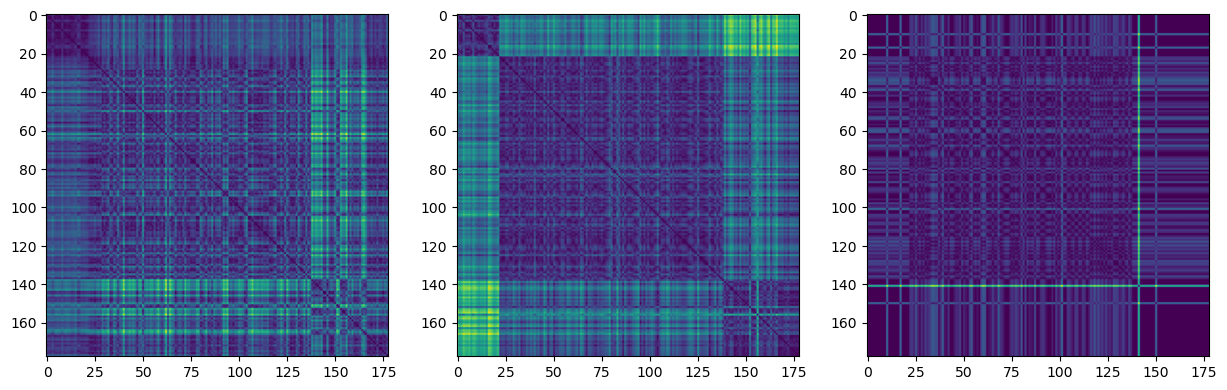

In [120]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_handed)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_handed)
plt.subplot(1,3,3)
plt.imshow(handed_rdm)
plt.show()

## RSA: Handedness

In [121]:
s_handedness_rsa = fit_rsa(s_patients_rdm_handed, handed_rdm)
s_handedness_rsa

0.07062918393598545

In [122]:
z_handedness_rsa = fit_rsa(z_patients_rdm_handed, handed_rdm)
z_handedness_rsa

0.030017500867769078

## RDMS: IQ

In [123]:
IQ_vector = ADHDdf['Full4 IQ'].values
IQ_vector

array([ 106.,   89.,   88.,   99.,   94.,  126.,  108.,  102.,  112.,
        113.,  119.,   86.,  103.,  134.,  126.,  121.,   94.,   89.,
        122.,  122.,   88.,   90.,  123.,  129.,  116.,  129.,  118.,
        107.,   99.,  125.,  108.,  125.,  119.,  107.,  125.,  115.,
        131.,  102.,  109.,   95.,   98.,  105.,  111.,  116.,   84.,
        107.,  114.,  109.,  134.,  124.,   97.,  107.,  132.,   99.,
        117.,  100.,  102.,  128.,  128.,  107.,   88.,  103.,  106.,
        102.,   95.,   95.,  108.,  119.,  109.,  115.,   94.,  109.,
        101.,  134.,   95.,  132.,   99.,  108.,  100.,   94.,   95.,
        105.,   92.,  103.,   89.,  109.,   91.,  108.,  108.,  109.,
        107., -999.,  118.,   99.,  122.,  101.,  122.,  101.,   94.,
        115.,  102.,  120.,  121.,   94.,   83.,   81.,  113.,   92.,
        115.,   75.,  106.,   93.,  129.,   99.,  114.,   84.,  131.,
         88.,   73.,  106., -999.,   78.,  102.,   95.,   99.,  127.,
         94.,  106.,

In [124]:
IQ_is_999 = IQ_vector==-999
IQ_is_999

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [125]:
IQ_is_nan = np.isnan(IQ_vector)

In [126]:
IQ_is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [127]:
IQ_is_not_nan = ~IQ_is_nan
IQ_is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [128]:
IQ_is_not_999 = ~IQ_is_999
IQ_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [129]:
IQ_good_subjects = IQ_is_not_999 * IQ_is_not_nan
IQ_good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [130]:
IQ_good_patients = IQ_vector[IQ_good_subjects]

In [131]:
s_patients_IQ = s_encoder.predict(data_patients)[0]
z_patients_IQ = z_encoder.predict(data_patients)[0]
IQ = np.array(IQ_good_patients)

In [132]:
z_good_patients_IQ = z_patients_IQ[IQ_good_subjects,:]

In [133]:
s_good_patients_IQ = s_patients_IQ[IQ_good_subjects,:]

In [134]:
s_patients_rdm_IQ = make_RDM(s_good_patients_IQ)
z_patients_rdm_IQ = make_RDM(z_good_patients_IQ)
IQ_rdm = make_RDM(IQ)

In [135]:
IQ_rdm.shape

(161, 161)

In [136]:
z_patients_rdm_IQ.shape

(161, 161)

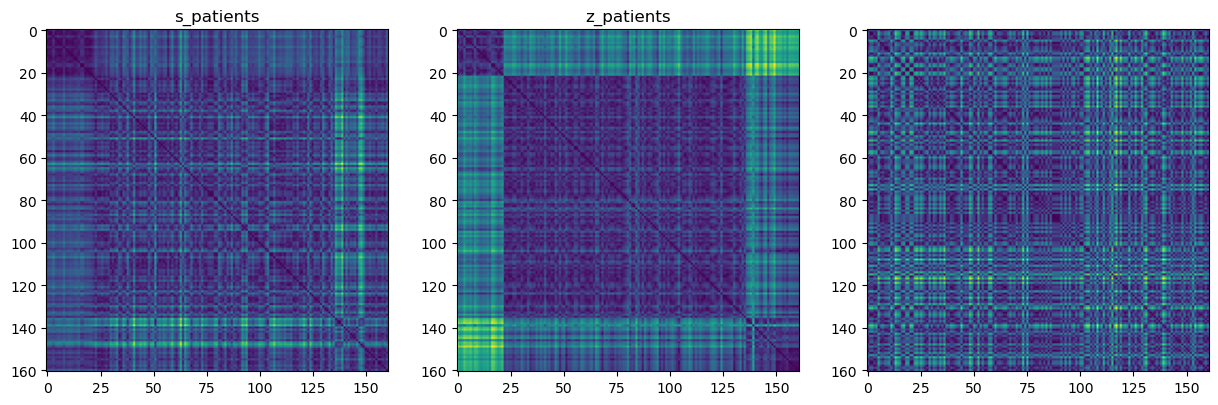

In [137]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_IQ)
plt.title('s_patients')
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_IQ)
plt.title('z_patients')
plt.subplot(1,3,3)
plt.imshow(IQ_rdm)
plt.show()

## RSA: IQ

In [138]:
s_iq_rsa = fit_rsa(s_patients_rdm_IQ, IQ_rdm)
s_iq_rsa

-0.02200086091519237

In [139]:
z_iq_rsa = fit_rsa(z_patients_rdm_IQ, IQ_rdm)
z_iq_rsa

-0.007970846964980176

## RDMS: Verbal IQ

In [140]:
verbal_vector = ADHDdf['Verbal IQ'].values
verbal_vector

array([ 122.,   89.,   93.,   93.,   93.,  138.,  106.,  108.,  116.,
        110.,  119.,  110.,   99.,  134.,  142.,  146.,   93.,   95.,
        106.,  112.,   81.,  100.,  115.,  131.,  109.,  109.,  122.,
        106.,  106.,  126.,  110.,  125.,  108.,   96.,  115.,  120.,
        141.,  101.,  109.,   98.,  108.,  114.,  115.,  107.,   88.,
        106.,  118.,   98.,  123.,  116.,   99.,  108.,  137.,  109.,
        123.,  104.,  107.,  135.,  123.,   98.,   99.,  106.,  106.,
        114.,   85.,   99.,  122.,  118.,  105.,  117.,  101.,  101.,
         97.,  136.,   95.,  130.,  106.,   98.,  102.,   89.,  105.,
        108.,   99.,  100.,   91.,  109.,  100.,  100.,   98.,  119.,
        109., -999.,  120.,   93.,  109.,   99.,  132.,   95.,  101.,
        122.,  104.,  116.,  113.,   96.,   77.,   81.,  119.,  107.,
        116.,   65.,  102.,   98.,  119.,  106.,  115.,   89.,  132.,
         92.,   77.,  106., -999.,   82.,  109.,   82.,  109.,  126.,
         98.,  115.,

In [141]:
verbal_is_999 = verbal_vector==-999
verbal_is_999

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [142]:
verbal_is_nan = np.isnan(verbal_vector)
verbal_is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [143]:
verbal_is_not_nan = ~verbal_is_nan
verbal_is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [144]:
verbal_is_not_999 = ~verbal_is_999
verbal_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [145]:
verbal_good_subjects = verbal_is_not_999 * verbal_is_not_nan
verbal_good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [146]:
verbal_good_patients = verbal_vector[verbal_good_subjects]

In [147]:
s_patients_verbal = s_encoder.predict(data_patients)[0]
z_patients_verbal = z_encoder.predict(data_patients)[0]
verbal = np.array(verbal_good_patients)

In [148]:
z_good_patients_verbal = z_patients_verbal[verbal_good_subjects,:]

In [149]:
s_good_patients_verbal = s_patients_verbal[verbal_good_subjects,:]

In [150]:
s_patients_rdm_verbal = make_RDM(s_good_patients_verbal)
z_patients_rdm_verbal = make_RDM(z_good_patients_verbal)
verbal_rdm = make_RDM(verbal)

In [151]:
verbal_rdm.shape

(147, 147)

In [152]:
z_patients_rdm_verbal.shape

(147, 147)

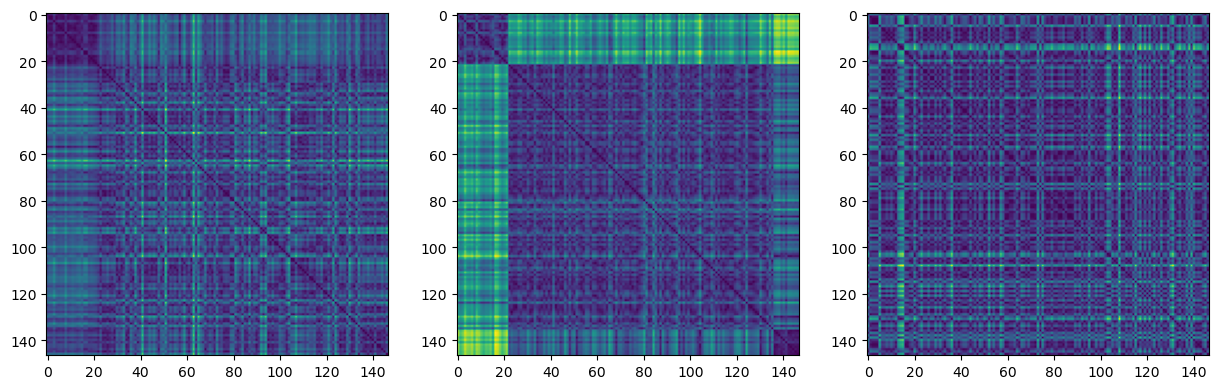

In [153]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_verbal)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_verbal)
plt.subplot(1,3,3)
plt.imshow(verbal_rdm)
plt.show()

## RSA: Verbal IQ

In [154]:
s_verbal_rsa = fit_rsa(s_patients_rdm_verbal, verbal_rdm)
s_verbal_rsa

-0.0036149844043853042

In [155]:
z_verbal_rsa = fit_rsa(z_patients_rdm_verbal, verbal_rdm)
z_verbal_rsa

0.0402224981969601

## RDMS: Performance IQ

In [156]:
performance_vector = ADHDdf['Performance IQ'].values
performance_vector

array([ 108.,   88.,   98.,  108.,  100.,  108.,  106.,  106.,  123.,
        123.,  125.,   79.,  115.,  129.,  119.,  106.,  112.,  106.,
        135.,  125.,   98.,   90.,  125.,  121.,  120.,  134.,  109.,
        106.,   91.,  119.,  104.,  117.,  128.,  118.,  129.,  106.,
        114.,  103.,  106.,   93.,   88.,   94.,  104.,  123.,   82.,
        107.,  107.,  120.,  137.,  126.,   95.,  103.,  119.,   88.,
        107.,   97.,   97.,  116.,  126.,   94.,   82.,  100.,  104.,
         89.,  107.,   92.,   93.,  117.,  111.,  109.,   88.,  116.,
        106.,  124.,   96.,  127.,   91.,  118.,   97.,  100.,   86.,
        100.,   87.,  105.,   91.,  106.,   85.,  115.,  119.,   97.,
        102., -999.,  111.,  104.,  131.,  103.,  107.,  107.,   88.,
        105.,   99.,  119.,  125.,   93.,   93.,   84.,  104.,   79.,
        115.,   89.,  107.,   89.,  133.,   91.,  109.,   83.,  123.,
         88.,   72.,  104., -999.,   79.,   93.,  108.,   88.,  121.,
         90.,   96.,

In [157]:
performance_is_999 = performance_vector==-999
performance_is_999

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [158]:
performance_is_nan = np.isnan(performance_vector)
performance_is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [159]:
performance_is_not_nan = ~performance_is_nan
performance_is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [160]:
performance_is_not_999 = ~performance_is_999
performance_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [161]:
performance_good_subjects = performance_is_not_999 * performance_is_not_nan
performance_good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [162]:
performance_good_patients = performance_vector[performance_good_subjects]

In [163]:
s_patients_performance = s_encoder.predict(data_patients)[0]
z_patients_performance = z_encoder.predict(data_patients)[0]
performance = np.array(performance_good_patients)

In [164]:
z_good_patients_performance = z_patients_performance[performance_good_subjects,:]

In [165]:
s_good_patients_performance = s_patients_performance[performance_good_subjects,:]

In [166]:
s_patients_rdm_performance = make_RDM(s_good_patients_performance)
z_patients_rdm_performance = make_RDM(z_good_patients_performance)
performance_rdm = make_RDM(performance)

In [167]:
performance_rdm.shape

(147, 147)

In [168]:
z_patients_rdm_performance.shape

(147, 147)

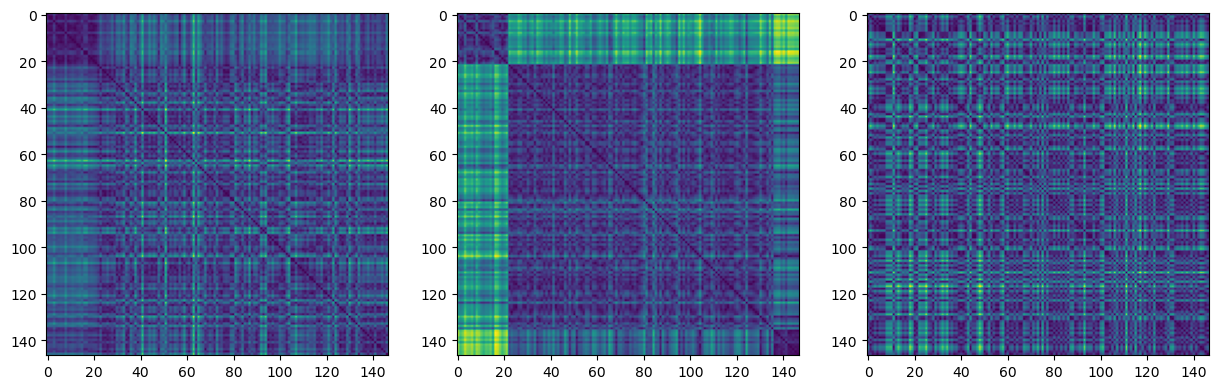

In [169]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_performance)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_performance)
plt.subplot(1,3,3)
plt.imshow(performance_rdm)
plt.show()

## RSA: Performance IQ

In [170]:
s_performance_rsa = fit_rsa(s_patients_rdm_performance, performance_rdm)
s_performance_rsa

-0.043824137515096735

In [171]:
z_performance_rsa = fit_rsa(z_patients_rdm_performance, performance_rdm)
z_performance_rsa

-0.010965756969290983

## RDMS: Site

In [172]:
site = ADHDdf['Site'].values
site

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [173]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
#site

In [174]:
s_patients_rdm = make_RDM(s_patients)
z_patients_rdm = make_RDM(z_patients)
site_rdm = make_RDM(site,data_scale='ordinal') # Ordinal data 

In [175]:
site_rdm.shape

(179, 179)

In [176]:
z_patients_rdm.shape

(179, 179)

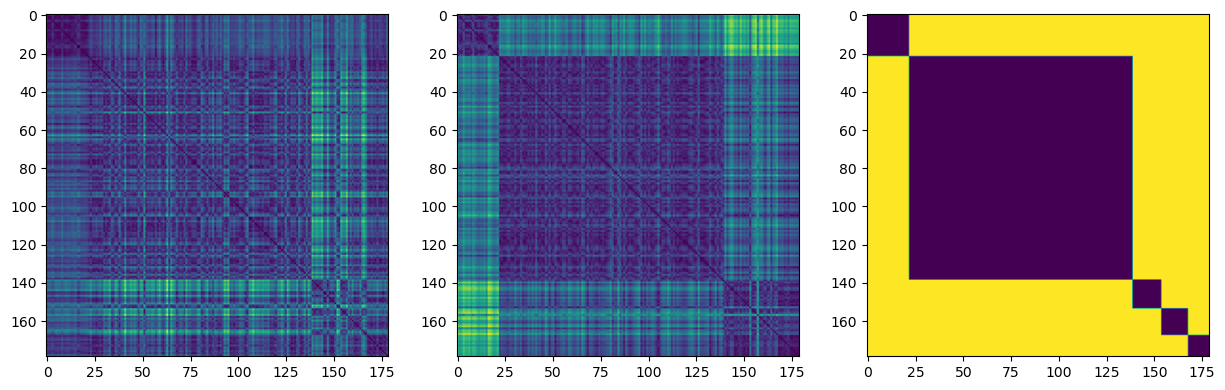

In [177]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm)
plt.subplot(1,3,3)
plt.imshow(site_rdm)
plt.show()

## RSA: Site

In [178]:
s_site_rsa = fit_rsa(s_patients_rdm, site_rdm)
s_site_rsa

0.3170643506128853

In [179]:
z_site_rsa = fit_rsa(z_patients_rdm, site_rdm)
z_site_rsa

0.615741744447048

## RSA Bar Plot

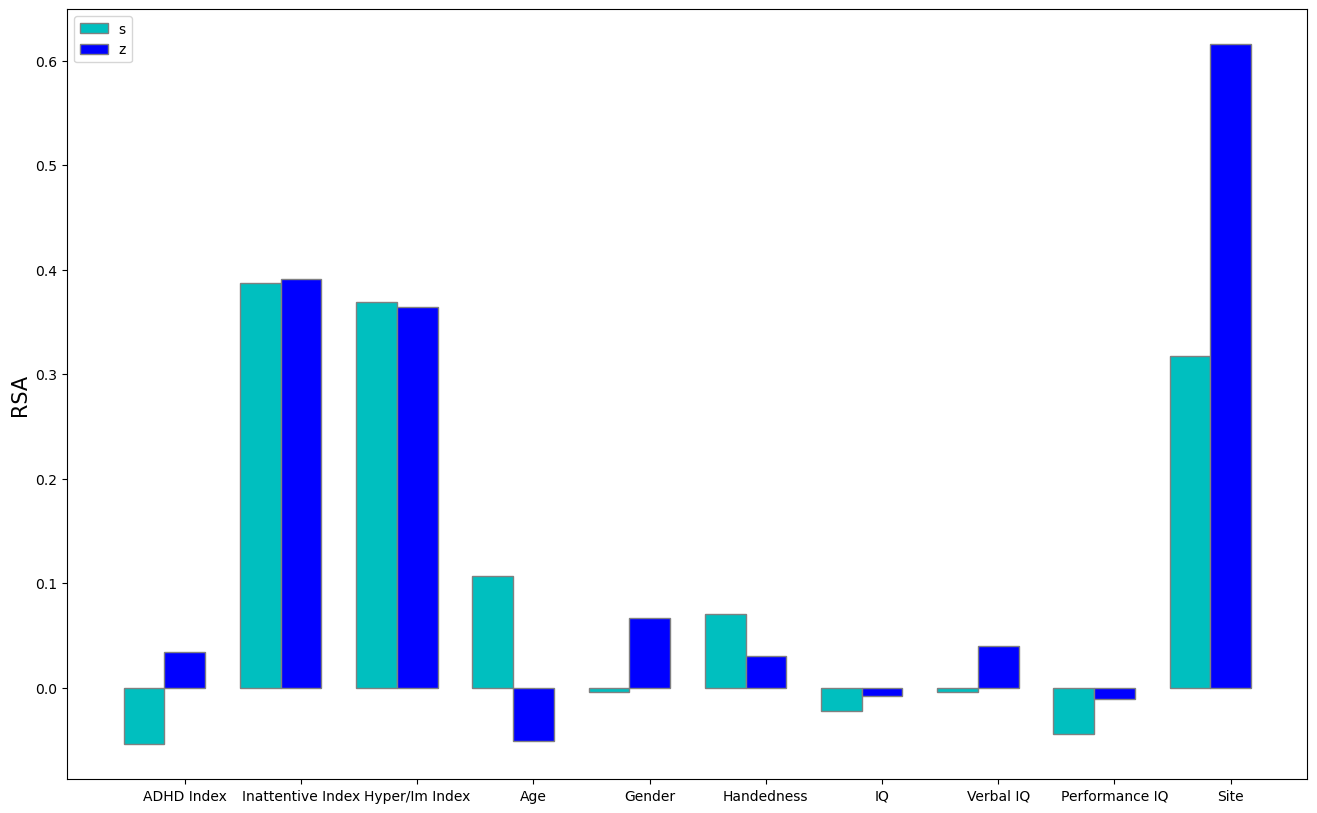

In [180]:
# set width of bar
barWidth = 0.35
fig = plt.subplots(figsize =(16, 10))

# set height of bar
s = [s_symptom_rsa, s_inattentive_rsa, s_HI_rsa, s_age_rsa, s_gender_rsa, s_handedness_rsa, s_iq_rsa, s_verbal_rsa, s_performance_rsa, s_site_rsa]
z = [z_symptom_rsa, z_inattentive_rsa, z_HI_rsa, z_age_rsa, z_gender_rsa, z_handedness_rsa, z_iq_rsa, z_verbal_rsa, z_performance_rsa, z_site_rsa]
 
# set position of bar on x axis
br1 = np.arange(len(s))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# make plot
plt.bar(br1, s, color ='c', width = barWidth,
        edgecolor ='grey', label ='s')
plt.bar(br2, z, color ='b', width = barWidth,
        edgecolor ='grey', label ='z')
 
# add xticks
# fontweight ='bold'
# plt.xlabel('Measure', fontsize = 15)
# title?
plt.ylabel('RSA', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(s))],
        ['ADHD Index', 'Inattentive Index', 'Hyper/Im Index', 'Age', 'Gender', 'Handedness', 'IQ', 'Verbal IQ', 'Performance IQ', 'Site'])
 
plt.legend()
plt.show()